# TP Eléments finis
## 1er partie : Poutre console en flexion

### Import des libraries

In [69]:
from fedoo import * #Import all the fedoo library
import numpy as np 
import time

### Paramètres
Bien vérifier la cohérence des unités et modifier si besoin

In [70]:
# paramètres géométriques et matériaux. Attention, il faut bien vérifier la cohérence des unités.
L = 200 #Longueur 
b = 50 #Largeur
h = 5 #Hauteur
E = 2e5 #Module d'Young
nu = 0.3 #Coefficient de Poisson
F = 100 #Force appliquer

#paramètres du maillage : 
type_el = 'quad9' #Type d'élément (à choisir entre 'tri3', 'tri6', 'quad4', 'quad8' et 'quad9')
Nx = 101 #Nombre de noeud suivant la direction x
Ny = 11 #Nombre de noeuds suivant la direction y

### Dimension de l'espace des solutions (1D, 2D ou 3D)

Dans cette partie nous allons uniquement considéré un modèle plan (2D). Dans FEDOO, c'est à cette étape que l'on choisit entre un modèle 2D plan en contraintes planes où 2D plan en déformations planes.
Ici, un modèle en contraintes planes est considéré ("2Dstress"). 

In [71]:
Util.ProblemDimension("2Dstress") #2D with plane stress assumption
#Util.ProblemDimension("2Dplane") #2D with plane strain assumption


Dimension of the problem is now set on 2Dstress


### Géométrie/Maillage
La fonction RectangleMesh est utilisé pour généré un maillage rectangulaire plan.

<IPython.core.display.Javascript object>


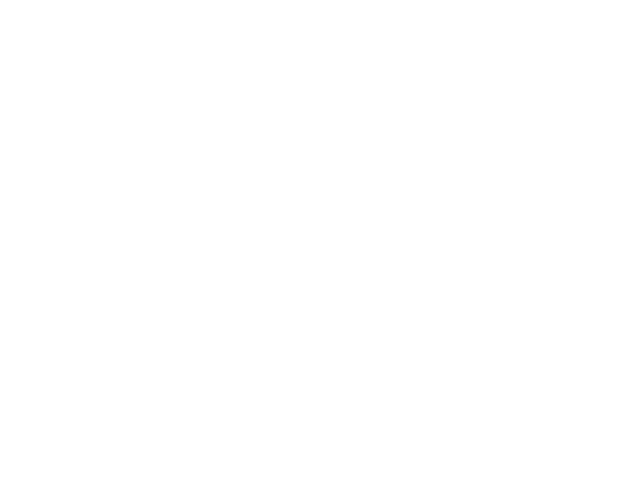

In [72]:
mesh = Mesh.RectangleMesh(Nx, Ny, x_min=0, x_max=L, y_min=0, y_max=h, ElementShape = type_el, ID ="Domain")
%matplotlib notebook
Util.meshPlot2d("Domain")

### Définition de la loi de comportement
Nous utilisons une loi de comportement Elastique, Linéaire, Homogène et Isotrope, que nous associons à une équation "InternalForce" (équation d'équilibre mécanique). Cela permet de définir le problème de minimisation de l'énergie potentielle, comme vu en cours.

In [73]:
ConstitutiveLaw.ElasticIsotrop(E, nu, ID = 'ElasticLaw')
WeakForm.InternalForce("ElasticLaw")

### Assemblage de la matice de rigidité globale

In [74]:
Assembly.Create("ElasticLaw", "Domain", type_el, ID="Assemblage", MeshChange=True) 
M = Assembly.GetAll()['Assemblage'].GetMatrix()
#print(M.todense())

### Définition du problème, conditions aux limites
A partir de l'assemblage, un problème statique linéaire est défini à partir du système :
$$ K u = F $$
où $K$ est la matrice de rigidité calculée lors de l'assemblage et $F$ est le vecteur des efforts exterieurs. 

In [75]:
Problem.Static("Assemblage")

<fedoo.libProblem.Problem_Static.Static.<locals>.__Static at 0x19c7e3e9188>

Pour inclure les conditions aux limites, il faut définir des listes de noeuds.
Ainsi, nous définissons les listes pour :
- le côté gauche (left) 
- le côté droit (right)
- le coin haut droit (top_right)

Pour cela, la fonction numpy np.where est utilisée pour trouver des noeuds à partir de leur coordonnées. 

In [76]:
#Definition of the set of nodes for boundary conditions
crd = mesh.GetNodeCoordinates() 
xmax = np.max(crd[:,0]) ; xmin = np.min(crd[:,0])
ymax = np.max(crd[:,1]) ; ymin = np.min(crd[:,1])
left = np.where(crd[:,0] == xmin)[0]
right = np.where(crd[:,0] == xmax)[0]
top_right = np.where( (crd[:,0] == xmax) * (crd[:,1] == ymax) )[0]

Nous utilisons la méthode BoundaryCondition pour appliquer les conditions aux limites. 
La syntaxe est : Problem.BoudaryCondition(type_CL, composante, valeur, list_noeuds) 
- Il est possible d'appliquer des conditions aux limites en déplacement (type_CL = 'Dirichlet') ou en effort (type_CL = 'Neumann').
- composante correspond à 'DispX' ou 'DispY' pour le déplacement/force suivant x ou y.
- valeur est la valeur du déplacement ou de la force (peut prendre une liste de valeur)
- list_noeuds est la liste des noeuds sur lesquels la condition est appliquée.

Il est important d'utiliser la méthode 'ApplyBoundaryCondition()' pour les inclure/actualiser les conditions aux limites. 

In [77]:
Problem.BoundaryCondition.RemoveAll() #in case there is already some boundary conditions defined
Problem.BoundaryCondition('Dirichlet','DispX', 0,left)
Problem.BoundaryCondition('Dirichlet','DispY', 0,left)
Problem.BoundaryCondition('Neumann','DispY',-F/b, top_right)
Problem.ApplyBoundaryCondition()

### Résolution
Here the conjugate gradient method is used (solver 'CG')

In [78]:
t0 = time.time() 
#Problem.SetSolver('cg')
print('Solving...')
Problem.Solve() 
print('Done in ' +str(time.time()-t0) + ' seconds')

Solving...
Done in 0.027127981185913086 seconds


### Affichage des résultats


Le flèche suivant Y est :  2.5592291161782588
La valeur théorique issue de la théorie des poutres est :  2.56


<IPython.core.display.Javascript object>


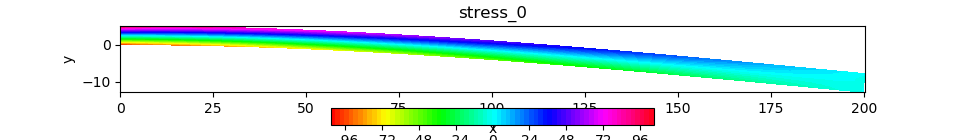

In [79]:
print("Le flèche suivant Y est : ", -Problem.GetDisp('DispY').min())
print("La valeur théorique issue de la théorie des poutres est : ", F*L**3/(3*E*b*h**3/12))
%matplotlib notebook
Util.fieldPlot2d("Domain", "ElasticLaw", Problem.GetDisp(), dataID = 'stress', component=0, scale_factor = 5, plot_edge = False, nb_level = 80, type_plot = "smooth")